In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import warnings

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# 0. Полезные функции

In [3]:
def isnan(value):
    return value is None or value != value

In [4]:
def analyze(series, categorical: bool = None):
    if isinstance(series, pd.DataFrame):
        series = series.iloc[:, 0]

    series_unique = sorted(series.unique())

    if categorical is None:
        categorical = len(series_unique) < 30

    max_len = 10

    print(
        f"unique: {len(series_unique)}",
        f"empty: {sum([isnan(el) for el in series])}",
        f"filled: {sum([not isnan(el) for el in series])},",
        f"values: {list(series_unique[:max_len]) + [] if len(series_unique) < max_len else ['...']}" if categorical else ""
    )
    if categorical:
        for val in series_unique[:max_len]:
            if isnan(val):
                print(f"{val} - {sum(series.isna())} times")
            else:
                print(f"{val} - {sum(series == val)} times")
        if len(series_unique) < 30:
            series.hist(xrot=-30)
    else:
        print(f"min: {series.min()}, mean: {series.mean()}, max: {series.max()}, std: {series.std()}")
        series.hist()
    plt.show()

# 1. Загрузка данных

In [5]:
df = pd.read_excel('placer_supplier.xlsx')
df

,contract_guid,contract_is_complete,contract_extension,purchase_type_code,notice_lot_max_contract_price,notice_lot_initial_sum,region_name,notice_lot_currency_code,supplier_inn,supplier_type,contract_placer_inn,contract_rub_price,contract_price,contract_start_execution_date,contract_end_execution_date,contracts_for_lot,contract_positions_count,lot_guid,real_rub_price,real_initial_sum,position_category,contract_category,economy,economy_percent,total_placer_contracts,total_placer_with_supplier_contracts,percent_placer_with_supplier_contracts,total_supplier_contracts,percent_supplier_with_placer_contracts,max_contract_positions_placer_supplier,mean_contract_positions_placer_supplier,total_contract_sum_placer_supplier,mean_contract_sum_placer_supplier,min_economy_placer_supplier,mean_economy_placer_supplier
0,001170e0-57c5-4d89-89f2-e607079cd321,1.0,0,40000,NaN,243570.00,Irkutskaya_obl,RUB,3460071768,Юридическое лицо,3821005886,NaN,243570.00,2020-08-11,2020-12-30,1,1,2d969aa4-9eed-42e1-8785-0f48ab2cfdea,243570.00,243570.00,['ХозОбор'],ХозОбор,0.0,0.000000,4,1,0.250000,1,1.000000,1,1.000000,243570.00,2.435700e+05,0.000000,0.000000
1,0019ca0a-9df7-43fe-a57a-1a76ace715c4,1.0,0,40000,NaN,358403.76,Vologodskaya_obl,RUB,7704543951,Юридическое лицо,3525147496,NaN,358403.76,2020-11-12,NaN,1,1,deea394b-d0ae-4163-803b-8e5eb8e7612d,358403.76,358403.76,['МедОбор'],МедОбор,0.0,0.000000,24,10,0.416667,27,0.370370,3,1.600000,5145375.13,5.145375e+05,0.000000,0.000000
2,003f036a-fdb3-40c0-b11b-b7d3428dff8b,NaN,0,40000,NaN,520000.00,Rostovskaya_obl,RUB,610601634808,Физическое лицо,6152000366,NaN,520000.00,2021-08-12,2021-08-30,1,1,32c09c3e-2c3e-4ee5-a265-66bc1fc9d7cc,520000.00,520000.00,['ХозМат'],ХозМат,0.0,0.000000,46,11,0.239130,11,1.000000,4,1.272727,4954000.00,4.503636e+05,0.000000,0.000000
3,004c1353-0d81-4f8f-9717-1ca1cf0258c9,1.0,0,40000,NaN,157470.00,Sverdlovskaya_obl,RUB,6671095570,Юридическое лицо,6623050480,NaN,157470.00,2021-06-20,2021-12-30,1,1,ac9dcc5e-2f5f-4e9d-b50c-bd9541688508,157470.00,157470.00,['МедМат'],МедМат,0.0,0.000000,17,12,0.705882,12,1.000000,4,1.916667,7242190.00,6.035158e+05,0.000000,0.000000
4,005196c2-7332-4b5c-a831-4f5470162d1b,1.0,0,40000,NaN,499850.00,Moskva,RUB,7726460307,Юридическое лицо,7709125605,NaN,499850.00,2020-03-18,2020-04-29,1,1,65d78fef-0b49-41d3-96a2-11114cb2f917,499850.00,499850.00,['МедМат'],МедМат,0.0,0.000000,5,1,0.200000,1,1.000000,1,1.000000,499850.00,4.998500e+05,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2944,ff208b6d-cc27-4a83-8bcb-e58421662cb2,1.0,0,30000,NaN,974997.49,Sankt-Peterburg,RUB,5321065111,Юридическое лицо,7802312751,NaN,974997.49,2021-05-18,NaN,1,7,20ef4eeb-e5ab-47a3-997b-629bb7adf3f2,974997.49,974997.49,"['ХозУслуги', 'ХозУслуги', 'ХозУслуги', 'ХозУслуги', 'ХозУслуги', 'ХозУслуги', 'ХозУслуги']",ХозУслуги,0.0,0.000000,1,1,1.000000,1,1.000000,7,7.000000,974997.49,9.749975e+05,0.000000,0.000000
2945,ff654b5e-5216-4414-9d72-89e6a496ac72,1.0,0,30000,NaN,193847.52,Sverdlovskaya_obl,RUB,6660139553,Юридическое лицо,6629007354,NaN,193847.52,2020-06-09,2020-12-30,1,2,fca8b00f-cabc-4d74-9fa7-335976eb0772,193847.52,193847.52,"['МедМат', 'ХозМат']",МедМат,0.0,0.000000,9,5,0.555556,6,0.833333,3,1.800000,2168562.02,4.337124e+05,0.000000,0.000000
2946,ffa6730b-a97d-43a6-925f-c67e2fba368b,1.0,0,40000,NaN,2208918.60,Tiumenskaya_obl,RUB,7207006570,Юридическое лицо,7203003137,NaN,2208918.60,2020-11-04,2020-12-11,1,1,171bb48b-b89e-493e-ab48-5a469d32079f,2208918.60,2208918.60,['Другое'],Другое,0.0,0.000000,28,1,0.035714,1,1.000000,1,1.000000,2208918.60,2.208919e+06,0.000000,0.000000
2947,ffa93893-b8ec-4a96-942c-1cc8bdb32e92,1.0,0,40000,NaN,300000.00,Leningradskaya_obl,RUB,463001373948,Физическое лицо,4705006785,NaN,374300.00,2020-06-01,2021-02-27,1,1,fc173f0f-f645-499a-9e19-62a32382c71c,374300.00,300000.00,['МедМат'],МедМат,-74300.0,-0.247667,2,2,1.000000,2,1.000000,1,1.000000,97280

# 2. Собираем выборку поставщик-заказчик с рассчитанными признаками

In [6]:
print(list(df.columns))

['contract_guid', 'contract_is_complete', 'contract_extension', 'purchase_type_code', 'notice_lot_max_contract_price', 'notice_lot_initial_sum', 'region_name', 'notice_lot_currency_code', 'supplier_inn', 'supplier_type', 'contract_placer_inn', 'contract_rub_price', 'contract_price', 'contract_start_execution_date', 'contract_end_execution_date', 'contracts_for_lot', 'contract_positions_count', 'lot_guid', 'real_rub_price', 'real_initial_sum', 'position_category', 'contract_category', 'economy', 'economy_percent', 'total_placer_contracts', 'total_placer_with_supplier_contracts', 'percent_placer_with_supplier_contracts', 'total_supplier_contracts', 'percent_supplier_with_placer_contracts', 'max_contract_positions_placer_supplier', 'mean_contract_positions_placer_supplier', 'total_contract_sum_placer_supplier', 'mean_contract_sum_placer_supplier', 'min_economy_placer_supplier', 'mean_economy_placer_supplier']


##### Рассчитанные признаки

In [9]:
calculated_features = [
    'mean_economy_placer_supplier',  # средняя экономия по лоту для пары
    'min_economy_placer_supplier',  # минимальная экономия по лоту для пары
    'mean_contract_sum_placer_supplier',  # средняя сумма договоров между заказчиком и поставщиком
    'total_contract_sum_placer_supplier',  # общая сумма договоров между заказчиком и поставщиком
    'mean_contract_positions_placer_supplier',  # среднее количество позиций в договоре для пары
    'max_contract_positions_placer_supplier',  # максимальное количество позиций в договоре для пары
    'percent_placer_with_supplier_contracts',  # процент договоров, которые заказчик заключил с этим поставщиком
    'percent_supplier_with_placer_contracts'  # процент договоров, которые поставщик заключил с этим заказчиком
]
supplier_placer = ['supplier_inn', 'contract_placer_inn']
df[calculated_features]

,mean_economy_placer_supplier,min_economy_placer_supplier,mean_contract_sum_placer_supplier,total_contract_sum_placer_supplier,mean_contract_positions_placer_supplier,max_contract_positions_placer_supplier,percent_placer_with_supplier_contracts,percent_supplier_with_placer_contracts
0,0.000000,0.000000,2.435700e+05,243570.00,1.000000,1,0.250000,1.000000
1,0.000000,0.000000,5.145375e+05,5145375.13,1.600000,3,0.416667,0.370370
2,0.000000,0.000000,4.503636e+05,4954000.00,1.272727,4,0.239130,1.000000
3,0.000000,0.000000,6.035158e+05,7242190.00,1.916667,4,0.705882,1.000000
4,0.000000,0.000000,4.998500e+05,499850.00,1.000000,1,0.200000,1.000000
...,...,...,...,...,...,...,...,...
2944,0.000000,0.000000,9.749975e+05,974997.49,7.000000,7,1.000000,1.000000
2945,0.000000,0.000000,4.337124e+05,2168562.02,1.800000,3,0.555556,0.833333
2946,0.000000,0.000000,2.208919e+06,2208918.60,1.000000,1,0.035714,1.000000
2947,-0.122583,-0.247667,4.864000e+05,972800.00,1.000000,1,1.000000,1.000000


In [10]:
df['supplier_placer_count'] = df.groupby(supplier_placer)['supplier_inn'].transform('size')
df

,contract_guid,contract_is_complete,contract_extension,purchase_type_code,notice_lot_max_contract_price,notice_lot_initial_sum,region_name,notice_lot_currency_code,supplier_inn,supplier_type,contract_placer_inn,contract_rub_price,contract_price,contract_start_execution_date,contract_end_execution_date,contracts_for_lot,contract_positions_count,lot_guid,real_rub_price,real_initial_sum,position_category,contract_category,economy,economy_percent,total_placer_contracts,total_placer_with_supplier_contracts,percent_placer_with_supplier_contracts,total_supplier_contracts,percent_supplier_with_placer_contracts,max_contract_positions_placer_supplier,mean_contract_positions_placer_supplier,total_contract_sum_placer_supplier,mean_contract_sum_placer_supplier,min_economy_placer_supplier,mean_economy_placer_supplier,supplier_placer_count
0,001170e0-57c5-4d89-89f2-e607079cd321,1.0,0,40000,NaN,243570.00,Irkutskaya_obl,RUB,3460071768,Юридическое лицо,3821005886,NaN,243570.00,2020-08-11,2020-12-30,1,1,2d969aa4-9eed-42e1-8785-0f48ab2cfdea,243570.00,243570.00,['ХозОбор'],ХозОбор,0.0,0.000000,4,1,0.250000,1,1.000000,1,1.000000,243570.00,2.435700e+05,0.000000,0.000000,1
1,0019ca0a-9df7-43fe-a57a-1a76ace715c4,1.0,0,40000,NaN,358403.76,Vologodskaya_obl,RUB,7704543951,Юридическое лицо,3525147496,NaN,358403.76,2020-11-12,NaN,1,1,deea394b-d0ae-4163-803b-8e5eb8e7612d,358403.76,358403.76,['МедОбор'],МедОбор,0.0,0.000000,24,10,0.416667,27,0.370370,3,1.600000,5145375.13,5.145375e+05,0.000000,0.000000,10
2,003f036a-fdb3-40c0-b11b-b7d3428dff8b,NaN,0,40000,NaN,520000.00,Rostovskaya_obl,RUB,610601634808,Физическое лицо,6152000366,NaN,520000.00,2021-08-12,2021-08-30,1,1,32c09c3e-2c3e-4ee5-a265-66bc1fc9d7cc,520000.00,520000.00,['ХозМат'],ХозМат,0.0,0.000000,46,11,0.239130,11,1.000000,4,1.272727,4954000.00,4.503636e+05,0.000000,0.000000,11
3,004c1353-0d81-4f8f-9717-1ca1cf0258c9,1.0,0,40000,NaN,157470.00,Sverdlovskaya_obl,RUB,6671095570,Юридическое лицо,6623050480,NaN,157470.00,2021-06-20,2021-12-30,1,1,ac9dcc5e-2f5f-4e9d-b50c-bd9541688508,157470.00,157470.00,['МедМат'],МедМат,0.0,0.000000,17,12,0.705882,12,1.000000,4,1.916667,7242190.00,6.035158e+05,0.000000,0.000000,12
4,005196c2-7332-4b5c-a831-4f5470162d1b,1.0,0,40000,NaN,499850.00,Moskva,RUB,7726460307,Юридическое лицо,7709125605,NaN,499850.00,2020-03-18,2020-04-29,1,1,65d78fef-0b49-41d3-96a2-11114cb2f917,499850.00,499850.00,['МедМат'],МедМат,0.0,0.000000,5,1,0.200000,1,1.000000,1,1.000000,499850.00,4.998500e+05,0.000000,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2944,ff208b6d-cc27-4a83-8bcb-e58421662cb2,1.0,0,30000,NaN,974997.49,Sankt-Peterburg,RUB,5321065111,Юридическое лицо,7802312751,NaN,974997.49,2021-05-18,NaN,1,7,20ef4eeb-e5ab-47a3-997b-629bb7adf3f2,974997.49,974997.49,"['ХозУслуги', 'ХозУслуги', 'ХозУслуги', 'ХозУслуги', 'ХозУслуги', 'ХозУслуги', 'ХозУслуги']",ХозУслуги,0.0,0.000000,1,1,1.000000,1,1.000000,7,7.000000,974997.49,9.749975e+05,0.000000,0.000000,1
2945,ff654b5e-5216-4414-9d72-89e6a496ac72,1.0,0,30000,NaN,193847.52,Sverdlovskaya_obl,RUB,6660139553,Юридическое лицо,6629007354,NaN,193847.52,2020-06-09,2020-12-30,1,2,fca8b00f-cabc-4d74-9fa7-335976eb0772,193847.52,193847.52,"['МедМат', 'ХозМат']",МедМат,0.0,0.000000,9,5,0.555556,6,0.833333,3,1.800000,2168562.02,4.337124e+05,0.000000,0.000000,5
2946,ffa6730b-a97d-43a6-925f-c67e2fba368b,1.0,0,40000,NaN,2208918.60,Tiumenskaya_obl,RUB,7207006570,Юридическое лицо,7203003137,NaN,2208918.60,2020-11-04,2020-12-11,1,1,171bb48b-b89e-493e-ab48-5a469d32079f,2208918.60,2208918.60,['Другое'],Другое,0.0,0.000000,28,1,0.035714,1,1.000000,1,1.000000,2208918.60,2.208919e+06,0.000000,0.000000,1
2947,ffa93893-b8ec-4a96-942c-1cc8bdb32e92,1.0,0,40000,NaN,300000.00,Leningradskaya_obl,RUB,463001373948,Физическое лицо,4705006785,NaN,374300.00,2020-06-01,2021-02-27,1,1,fc173f0f-f645-499a-9e19-62a32382c71c,374300.00,300000.00,['МедМат'],МедМат,-74300.0,-0.24

In [11]:
# Удалим пары, которые встречаются по одному разу. Так как на их основе не построить устойчивую связь
drop_single_supplier_placer = True
if drop_single_supplier_placer:
    df = df[df['supplier_placer_count'] > 1]
df

,contract_guid,contract_is_complete,contract_extension,purchase_type_code,notice_lot_max_contract_price,notice_lot_initial_sum,region_name,notice_lot_currency_code,supplier_inn,supplier_type,contract_placer_inn,contract_rub_price,contract_price,contract_start_execution_date,contract_end_execution_date,contracts_for_lot,contract_positions_count,lot_guid,real_rub_price,real_initial_sum,position_category,contract_category,economy,economy_percent,total_placer_contracts,total_placer_with_supplier_contracts,percent_placer_with_supplier_contracts,total_supplier_contracts,percent_supplier_with_placer_contracts,max_contract_positions_placer_supplier,mean_contract_positions_placer_supplier,total_contract_sum_placer_supplier,mean_contract_sum_placer_supplier,min_economy_placer_supplier,mean_economy_placer_supplier,supplier_placer_count
1,0019ca0a-9df7-43fe-a57a-1a76ace715c4,1.0,0,40000,NaN,358403.76,Vologodskaya_obl,RUB,7704543951,Юридическое лицо,3525147496,NaN,358403.76,2020-11-12,NaN,1,1,deea394b-d0ae-4163-803b-8e5eb8e7612d,358403.76,358403.76,['МедОбор'],МедОбор,0.0,0.000000,24,10,0.416667,27,0.370370,3,1.600000,5145375.13,514537.513000,0.000000,0.000000,10
2,003f036a-fdb3-40c0-b11b-b7d3428dff8b,NaN,0,40000,NaN,520000.00,Rostovskaya_obl,RUB,610601634808,Физическое лицо,6152000366,NaN,520000.00,2021-08-12,2021-08-30,1,1,32c09c3e-2c3e-4ee5-a265-66bc1fc9d7cc,520000.00,520000.00,['ХозМат'],ХозМат,0.0,0.000000,46,11,0.239130,11,1.000000,4,1.272727,4954000.00,450363.636364,0.000000,0.000000,11
3,004c1353-0d81-4f8f-9717-1ca1cf0258c9,1.0,0,40000,NaN,157470.00,Sverdlovskaya_obl,RUB,6671095570,Юридическое лицо,6623050480,NaN,157470.00,2021-06-20,2021-12-30,1,1,ac9dcc5e-2f5f-4e9d-b50c-bd9541688508,157470.00,157470.00,['МедМат'],МедМат,0.0,0.000000,17,12,0.705882,12,1.000000,4,1.916667,7242190.00,603515.833333,0.000000,0.000000,12
5,00954370-200e-403a-997b-f469f075967e,NaN,0,30000,NaN,292407.00,Krasnodarskii_krai,RUB,2308185326,Юридическое лицо,2312210286,NaN,292407.00,2020-03-15,NaN,1,1,15fd6ba3-3df0-41da-b2ce-e2a8fef5800c,292407.00,292407.00,['Строительство'],Строительство,0.0,0.000000,50,20,0.400000,20,1.000000,1,1.000000,5470996.00,273549.800000,0.000000,0.000000,20
7,00a78395-bf17-4894-97fc-5ca229521d40,1.0,0,40000,NaN,122314.39,Saratovskaya_obl,RUB,6454074043,Юридическое лицо,6454006283,NaN,122314.39,NaN,NaN,1,1,e11b8e44-8990-4a5e-a77f-c8f4f2ec9632,122314.39,122314.39,['ХозУслуги'],ХозУслуги,0.0,0.000000,53,35,0.660377,35,1.000000,3,1.257143,5267204.69,150491.562571,0.000000,0.000000,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2940,fee6970b-505a-4e7d-bdae-3ebbabb7e723,1.0,0,40000,NaN,1500000.00,Moskva,RUB,7707300410,Юридическое лицо,7729101120,NaN,222615.00,2020-10-19,2020-12-30,1,1,3600b5fa-979b-4926-9694-3b5a4c15afd8,222615.00,1500000.00,['МедМат'],МедМат,1277385.0,0.851590,67,7,0.104478,7,1.000000,1,1.000000,4661277.45,665896.778571,0.030000,0.484802,7
2941,fee8f2e0-3a58-48cf-8990-20420d2ebc17,1.0,0,40000,NaN,406450.00,Tiumenskaya_obl,RUB,7203462204,Юридическое лицо,7207000070,NaN,406450.00,2020-04-06,2020-04-29,1,1,5a7a0e6c-b635-4d8f-bc82-895213b885e7,406450.00,406450.00,['МедМат'],МедМат,0.0,0.000000,4,3,0.750000,12,0.250000,1,1.000000,1318314.00,439438.000000,0.000000,0.000000,3
2945,ff654b5e-5216-4414-9d72-89e6a496ac72,1.0,0,30000,NaN,193847.52,Sverdlovskaya_obl,RUB,6660139553,Юридическое лицо,6629007354,NaN,193847.52,2020-06-09,2020-12-30,1,2,fca8b00f-cabc-4d74-9fa7-335976eb0772,193847.52,193847.52,"['МедМат', 'ХозМат']",МедМат,0.0,0.000000,9,5,0.555556,6,0.833333,3,1.800000,2168562.02,433712.404000,0.000000,0.000000,5
2947,ffa93893-b8ec-4a96-942c-1cc8bdb32e92,1.0,0,40000,NaN,300000.00,Leningradskaya_obl,RUB,463001373948,Физическое лицо,4705006785,NaN,374300.00,2020-06-01,2021-02-27,1,1,fc173f0f-f645-499a-9e19-62a32382c71c,374300.00,300000.00,['МедМат'],МедМат,-74300.0,-0.247667,2,2,1.000000,2,1.000000,1,1.000000,972800.00,486

In [12]:
df['supplier_inn'] = df.apply(
    lambda row: str(row['supplier_inn']),
    axis=1
)
df['contract_placer_inn'] = df.apply(
    lambda row: str(row['contract_placer_inn']),
    axis=1
)
df = df[supplier_placer + calculated_features].drop_duplicates()
df

/Users/user/shit/zakupki-analytics/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/user/shit/zakupki-analytics/venv/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,supplier_inn,contract_placer_inn,mean_economy_placer_supplier,min_economy_placer_supplier,mean_contract_sum_placer_supplier,total_contract_sum_placer_supplier,mean_contract_positions_placer_supplier,max_contract_positions_placer_supplier,percent_placer_with_supplier_contracts,percent_supplier_with_placer_contracts
1,7704543951,3525147496,0.000000,0.00000,5.145375e+05,5145375.13,1.600000,3,0.416667,0.370370
2,610601634808,6152000366,0.000000,0.00000,4.503636e+05,4954000.00,1.272727,4,0.239130,1.000000
3,6671095570,6623050480,0.000000,0.00000,6.035158e+05,7242190.00,1.916667,4,0.705882,1.000000
5,2308185326,2312210286,0.000000,0.00000,2.735498e+05,5470996.00,1.000000,1,0.400000,1.000000
7,6454074043,6454006283,0.000000,0.00000,1.504916e+05,5267204.69,1.257143,3,0.660377,1.000000
...,...,...,...,...,...,...,...,...,...,...
2607,7451344670,7453014519,0.000000,0.00000,3.023096e+06,6046193.00,3.000000,5,0.285714,1.000000
2689,772794006294,7729101120,0.410760,0.12952,2.561200e+06,5122400.00,1.000000,1,0.029851,1.000000
2714,1435157979,1435029085,0.000000,0.00000,1.000000e-02,0.02,1.000000,1,0.666667,0.666667
2754,274956493,256996711,0.000000,0.00000,8.850000e+05,1770000.00,1.000000,1,1.000000,1.000000


# 3. Анализ признаков и удаление выбросов

In [61]:
dataset = df

In [62]:
print(list(dataset.columns))

['supplier_inn', 'contract_placer_inn', 'mean_economy_placer_supplier', 'min_economy_placer_supplier', 'mean_contract_sum_placer_supplier', 'total_contract_sum_placer_supplier', 'mean_contract_positions_placer_supplier', 'max_contract_positions_placer_supplier', 'percent_placer_with_supplier_contracts', 'percent_supplier_with_placer_contracts']


### Средняя экономия по лоту для пары

unique: 108 empty: 0 filled: 461, 
min: -0.75, mean: 0.020910152367293294, max: 0.83562, std: 0.11230510163090057


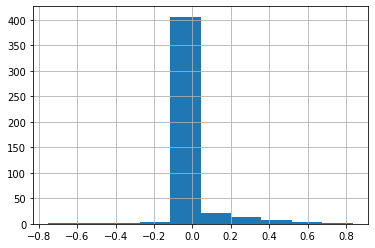

In [63]:
analyze(dataset['mean_economy_placer_supplier'])

### Минимальная экономия по лоту для пары

unique: 67 empty: 0 filled: 461, 
min: -2.071328671328671, mean: -0.007109042205248171, max: 0.75044, std: 0.15234869202810639


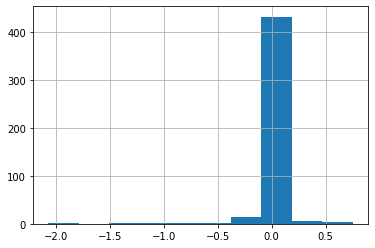

In [64]:
analyze(dataset['min_economy_placer_supplier'])

##### удаляем слишком большую экономию

In [65]:
dataset[dataset['min_economy_placer_supplier'] > 0.4]

,supplier_inn,contract_placer_inn,mean_economy_placer_supplier,min_economy_placer_supplier,mean_contract_sum_placer_supplier,total_contract_sum_placer_supplier,mean_contract_positions_placer_supplier,max_contract_positions_placer_supplier,percent_placer_with_supplier_contracts,percent_supplier_with_placer_contracts
386,7701755549,7729101120,0.835620,0.750440,161390.00,322780.00,2.0,2,0.029851,1.0
977,3851017720,3808069986,0.489841,0.475838,369790.00,739580.00,1.0,1,1.000000,1.0
1193,7731196376,7729101120,0.692476,0.595140,153762.00,307524.00,1.0,1,0.029851,1.0
1879,6829105486,6825000757,0.616239,0.611193,100800.48,201600.96,1.0,1,0.500000,1.0


In [66]:
dataset = dataset[dataset['min_economy_placer_supplier'] <= 0.4]

##### удаляем слишком маленькую экономию

In [67]:
dataset[dataset['min_economy_placer_supplier'] < -0.2]

,supplier_inn,contract_placer_inn,mean_economy_placer_supplier,min_economy_placer_supplier,mean_contract_sum_placer_supplier,total_contract_sum_placer_supplier,mean_contract_positions_placer_supplier,max_contract_positions_placer_supplier,percent_placer_with_supplier_contracts,percent_supplier_with_placer_contracts
17,616511897803,6152000366,-0.035294,-0.666667,1.569713e+05,2668512.00,1.0,1,0.369565,1.000000
30,4634010140,4632060153,-0.169607,-0.508820,3.348882e+06,10046644.90,1.0,1,1.000000,1.000000
274,7325019247,7328014430,-0.375000,-0.950000,7.731215e+05,1546243.02,1.0,1,0.062500,1.000000
1372,2308108201,2308065678,-0.750000,-1.500000,6.984900e+06,13969800.00,1.0,1,0.117647,1.000000
1688,2457070106,7838041248,-0.517832,-2.071329,1.292480e+07,51699200.00,1.0,1,0.266667,1.000000
2242,7203462204,7224013707,-0.161660,-0.323319,1.377250e+05,275450.00,2.0,3,0.181818,0.166667
2261,7202086042,7224009059,-0.279486,-0.279503,2.558891e+06,5117781.60,1.0,1,0.021505,1.000000
2315,463001373948,4705006785,-0.122583,-0.247667,4.864000e+05,972800.00,1.0,1,1.000000,1.000000


In [68]:
dataset = dataset[dataset['min_economy_placer_supplier'] >= -0.2]

unique: 55 empty: 0 filled: 449, 
min: -0.2, mean: 0.001865090019311481, max: 0.3375394321766562, std: 0.04201462478067585


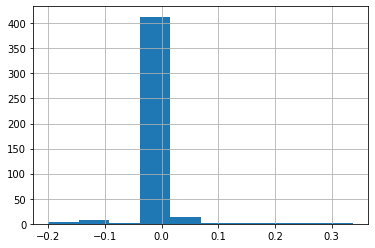

In [69]:
analyze(dataset['min_economy_placer_supplier'])

### Средняя сумма договоров между заказчиком и поставщиком

unique: 442 empty: 0 filled: 449, 
min: 0.01, mean: 3827768.7825797317, max: 758274769.125, std: 36512327.5028716


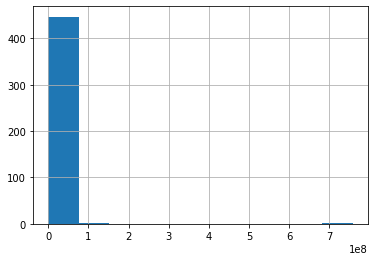

In [70]:
analyze(dataset['mean_contract_sum_placer_supplier'])

In [71]:
dataset[dataset['mean_contract_sum_placer_supplier'] > 7000000]

,supplier_inn,contract_placer_inn,mean_economy_placer_supplier,min_economy_placer_supplier,mean_contract_sum_placer_supplier,total_contract_sum_placer_supplier,mean_contract_positions_placer_supplier,max_contract_positions_placer_supplier,percent_placer_with_supplier_contracts,percent_supplier_with_placer_contracts
66,7802684816,7838041248,0.000000e+00,0.000000,1.637367e+07,4.912100e+07,1.000000,1,0.200000,1.000000
105,3305795861,3325008103,0.000000e+00,0.000000,5.152500e+07,1.545750e+08,1.000000,1,0.100000,1.000000
126,7727803780,5036065113,9.999999e-04,0.001000,1.678264e+07,5.034791e+07,1.000000,1,0.130435,1.000000
131,6453153422,6454028569,0.000000e+00,0.000000,1.026000e+07,2.052000e+07,1.000000,1,0.051282,1.000000
153,7727391286,7705035012,0.000000e+00,0.000000,4.000000e+07,8.000000e+07,1.000000,1,0.125000,1.000000
175,7731373530,3201001120,0.000000e+00,0.000000,3.915960e+07,1.174788e+08,1.000000,1,0.013158,0.750000
211,6685139668,8905026850,0.000000e+00,0.000000,7.459024e+06,1.491805e+07,14.000000,27,0.142857,1.000000
243,7725328521,3443012297,0.000000e+00,0.000000,3.558117e+07,1.067435e+08,1.333333,2,0.061224,1.000000
294,7706814981,7705035012,0.000000e+00,0.000000,8.070000e+06,1.614000e+07,1.000000,1,0.125000,1.000000
330,5017112368,3443012297,0.000000e+00,0.000000,3.276734e+07,3.276734e+08,1.200000,2,0.204082,1.000000


In [72]:
dataset = dataset[dataset['mean_contract_sum_placer_supplier'] <= 7000000]

unique: 421 empty: 0 filled: 428, 
min: 0.01, mean: 950922.8719888228, max: 6280253.33, std: 1196638.9119380596


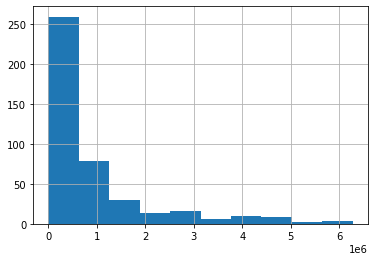

In [73]:
analyze(dataset['mean_contract_sum_placer_supplier'])

### Общая сумма договоров между заказчиком и поставщиком

unique: 421 empty: 0 filled: 428, 
min: 0.02, mean: 3721984.1048598136, max: 52717043.14, std: 6622703.004254672


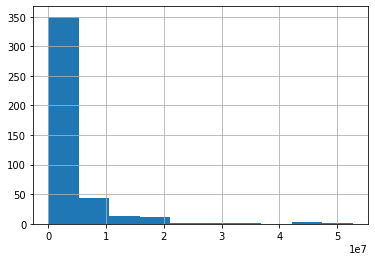

In [74]:
analyze(dataset['total_contract_sum_placer_supplier'])

### Среднее количество позиций в договоре для пары

unique: 56 empty: 0 filled: 428, 
min: 1.0, mean: 1.6186232966827172, max: 18.0, std: 1.766208848933747


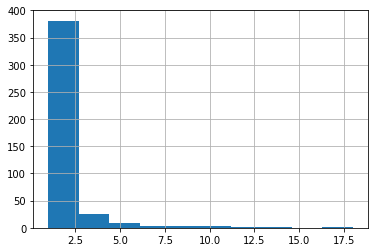

In [75]:
analyze(dataset['mean_contract_positions_placer_supplier'], categorical=False)

In [76]:
dataset[dataset['mean_contract_positions_placer_supplier'] > 10]

,supplier_inn,contract_placer_inn,mean_economy_placer_supplier,min_economy_placer_supplier,mean_contract_sum_placer_supplier,total_contract_sum_placer_supplier,mean_contract_positions_placer_supplier,max_contract_positions_placer_supplier,percent_placer_with_supplier_contracts,percent_supplier_with_placer_contracts
112,2634059368,2633001291,0.000000,0.000000,239086.000,478172.00,13.0,13,0.285714,1.000000
277,7816363890,7806000721,0.041886,0.025975,212709.500,425419.00,11.0,21,0.333333,0.153846
867,7816363890,7806004042,0.027204,0.023933,144415.500,288831.00,12.0,23,0.285714,0.153846
1256,7709286850,3812014066,0.000000,0.000000,108419.400,216838.80,18.0,19,0.400000,1.000000
1714,2539071132,2539007634,0.000000,0.000000,228955.565,457911.13,11.0,19,0.400000,1.000000


In [77]:
dataset = dataset[dataset['mean_contract_positions_placer_supplier'] <= 10]

unique: 52 empty: 0 filled: 423, 
min: 1.0, mean: 1.4840916571636007, max: 9.5, std: 1.2340828803143675


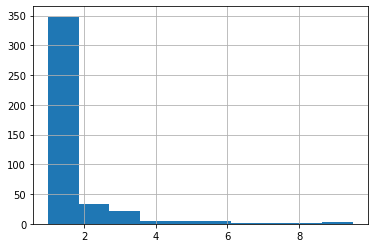

In [78]:
analyze(dataset['mean_contract_positions_placer_supplier'])

### Максимальное количество позиций в договоре для пары

unique: 17 empty: 0 filled: 423, 
min: 1, mean: 2.054373522458629, max: 34, std: 2.881444727557734


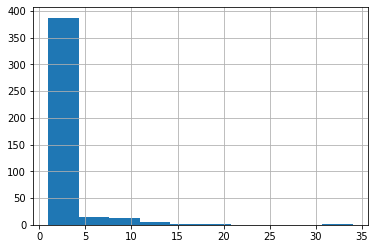

In [59]:
analyze(dataset['max_contract_positions_placer_supplier'], categorical=False)

In [79]:
dataset[dataset['max_contract_positions_placer_supplier'] > 30]

,supplier_inn,contract_placer_inn,mean_economy_placer_supplier,min_economy_placer_supplier,mean_contract_sum_placer_supplier,total_contract_sum_placer_supplier,mean_contract_positions_placer_supplier,max_contract_positions_placer_supplier,percent_placer_with_supplier_contracts,percent_supplier_with_placer_contracts
280,7801493343,7811153258,0.0,0.0,705922.058235,12000674.99,3.529412,34,0.53125,0.894737


In [80]:
dataset = dataset[dataset['max_contract_positions_placer_supplier'] <= 30]

unique: 16 empty: 0 filled: 422, 
min: 1, mean: 1.9786729857819905, max: 18, std: 2.4274792928129623


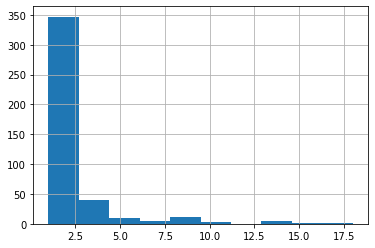

In [83]:
analyze(dataset['max_contract_positions_placer_supplier'], categorical=False)

### Процент договоров, которые заказчик заключил с этим поставщиком

unique: 129 empty: 0 filled: 422, 
min: 0.008771929824561403, mean: 0.3371572462591295, max: 1.0, std: 0.32284845840798665


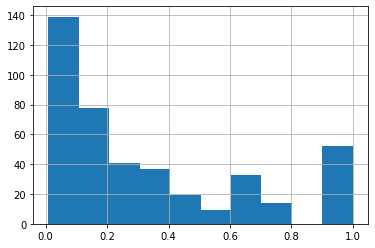

In [84]:
analyze(dataset['percent_placer_with_supplier_contracts'])

### Процент договоров, которые поставщик заключил с этим заказчиком

unique: 42 empty: 0 filled: 422, 
min: 0.04, mean: 0.839313955955263, max: 1.0, std: 0.2810077289924273


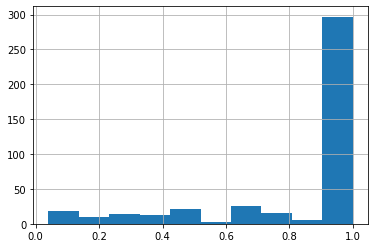

In [85]:
analyze(dataset['percent_supplier_with_placer_contracts'], categorical=False)

# 4. Стандартизируем признаки

In [86]:
data = dataset[calculated_features]
data = (data - data.mean()) / data.std()
data

,mean_economy_placer_supplier,min_economy_placer_supplier,mean_contract_sum_placer_supplier,total_contract_sum_placer_supplier,mean_contract_positions_placer_supplier,max_contract_positions_placer_supplier,percent_placer_with_supplier_contracts,percent_supplier_with_placer_contracts
1,-0.258187,-0.032770,-0.371021,0.211108,0.098054,0.420736,0.246275,-1.668792
2,-0.258187,-0.032770,-0.424404,0.182319,-0.167695,0.832686,-0.303631,0.571821
3,-0.258187,-0.032770,-0.297005,0.526539,0.355191,0.832686,1.142100,0.571821
5,-0.258187,-0.032770,-0.571486,0.260092,-0.389152,-0.403164,0.194651,0.571821
7,-0.258187,-0.032770,-0.673852,0.229435,-0.180349,0.420736,1.001151,0.571821
...,...,...,...,...,...,...,...,...
2607,-0.258187,-0.032770,1.715717,0.346621,1.234870,1.244636,-0.159341,0.571821
2689,4.802493,3.139933,1.331490,0.207652,-0.389152,-0.403164,-0.951860,0.571821
2714,-0.258187,-0.032770,-0.799038,-0.562928,-0.389152,-0.403164,1.020632,-0.614386
2754,-0.258187,-0.032770,-0.062853,-0.296661,-0.389152,-0.403164,2.053108,0.571821


In [87]:
dataset[calculated_features] = data
dataset

,supplier_inn,contract_placer_inn,mean_economy_placer_supplier,min_economy_placer_supplier,mean_contract_sum_placer_supplier,total_contract_sum_placer_supplier,mean_contract_positions_placer_supplier,max_contract_positions_placer_supplier,percent_placer_with_supplier_contracts,percent_supplier_with_placer_contracts
1,7704543951,3525147496,-0.258187,-0.032770,-0.371021,0.211108,0.098054,0.420736,0.246275,-1.668792
2,610601634808,6152000366,-0.258187,-0.032770,-0.424404,0.182319,-0.167695,0.832686,-0.303631,0.571821
3,6671095570,6623050480,-0.258187,-0.032770,-0.297005,0.526539,0.355191,0.832686,1.142100,0.571821
5,2308185326,2312210286,-0.258187,-0.032770,-0.571486,0.260092,-0.389152,-0.403164,0.194651,0.571821
7,6454074043,6454006283,-0.258187,-0.032770,-0.673852,0.229435,-0.180349,0.420736,1.001151,0.571821
...,...,...,...,...,...,...,...,...,...,...
2607,7451344670,7453014519,-0.258187,-0.032770,1.715717,0.346621,1.234870,1.244636,-0.159341,0.571821
2689,772794006294,7729101120,4.802493,3.139933,1.331490,0.207652,-0.389152,-0.403164,-0.951860,0.571821
2714,1435157979,1435029085,-0.258187,-0.032770,-0.799038,-0.562928,-0.389152,-0.403164,1.020632,-0.614386
2754,274956493,256996711,-0.258187,-0.032770,-0.062853,-0.296661,-0.389152,-0.403164,2.053108,0.571821


# 5. Отбрасываем признаки, которые сильно коррелируют

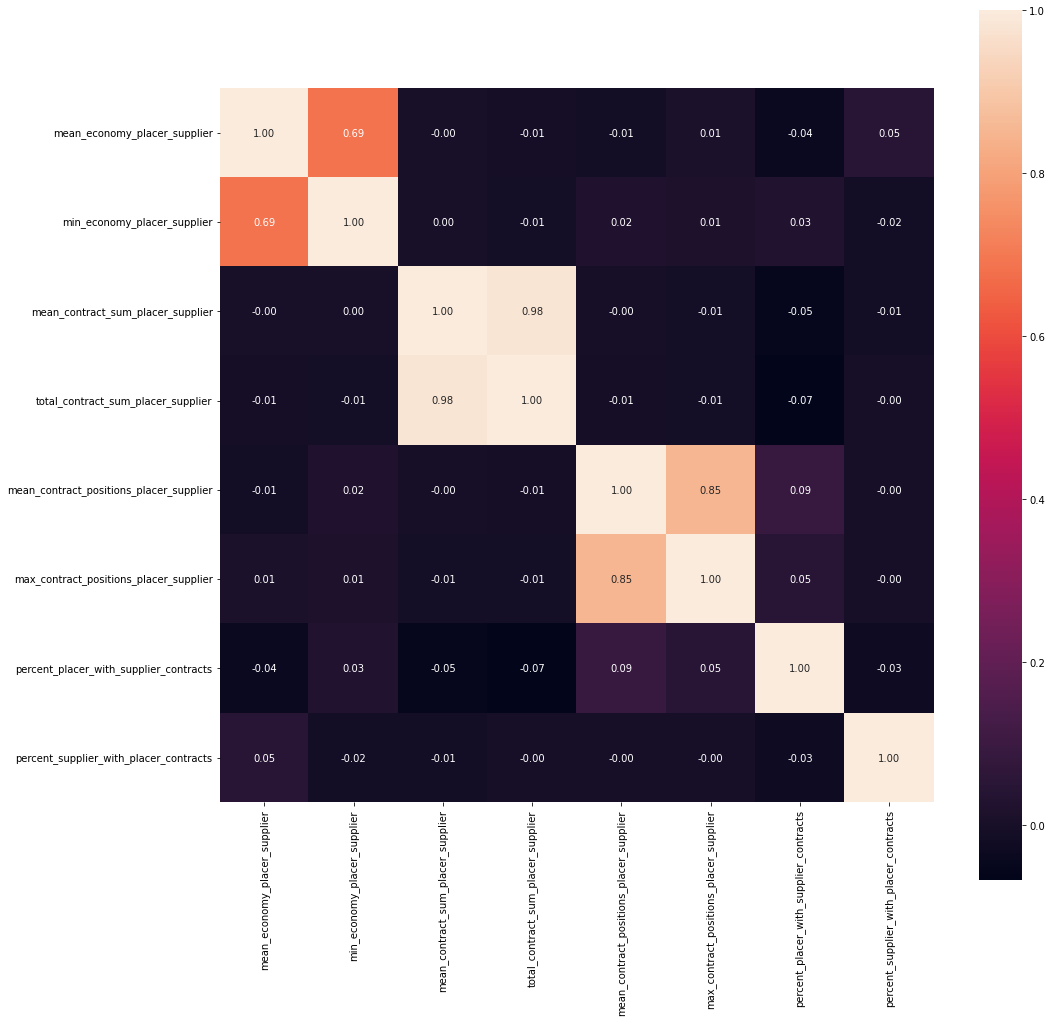

In [88]:
plt.figure(figsize=(16, 16))
sns.heatmap(df.corr(), annot=True, fmt='.2f', square=True)
plt.yticks(rotation='horizontal');

Видна корреляция между следующими признаками:

средняя экономия - минимальная экономия
средняя сумма - общая сумма
среднее количество позиций - максимальное количество позиций

In [89]:
columns = list(df.columns)
if 'min_economy_placer_supplier' in columns:
    columns.remove('min_economy_placer_supplier')
if 'total_contract_sum_placer_supplier' in columns:
    columns.remove('total_contract_sum_placer_supplier')
if 'max_contract_positions_placer_supplier' in columns:
    columns.remove('max_contract_positions_placer_supplier')
if 'min_economy_placer_supplier' in calculated_features:
    calculated_features.remove('min_economy_placer_supplier')
if 'total_contract_sum_placer_supplier' in calculated_features:
    calculated_features.remove('total_contract_sum_placer_supplier')
if 'max_contract_positions_placer_supplier' in calculated_features:
    calculated_features.remove('max_contract_positions_placer_supplier')
dataset = dataset[columns]
dataset

,supplier_inn,contract_placer_inn,mean_economy_placer_supplier,mean_contract_sum_placer_supplier,mean_contract_positions_placer_supplier,percent_placer_with_supplier_contracts,percent_supplier_with_placer_contracts
1,7704543951,3525147496,-0.258187,-0.371021,0.098054,0.246275,-1.668792
2,610601634808,6152000366,-0.258187,-0.424404,-0.167695,-0.303631,0.571821
3,6671095570,6623050480,-0.258187,-0.297005,0.355191,1.142100,0.571821
5,2308185326,2312210286,-0.258187,-0.571486,-0.389152,0.194651,0.571821
7,6454074043,6454006283,-0.258187,-0.673852,-0.180349,1.001151,0.571821
...,...,...,...,...,...,...,...
2607,7451344670,7453014519,-0.258187,1.715717,1.234870,-0.159341,0.571821
2689,772794006294,7729101120,4.802493,1.331490,-0.389152,-0.951860,0.571821
2714,1435157979,1435029085,-0.258187,-0.799038,-0.389152,1.020632,-0.614386
2754,274956493,256996711,-0.258187,-0.062853,-0.389152,2.053108,0.571821


# 6. Кластеризация

In [90]:
import scipy.cluster as clst

In [91]:
data = dataset[calculated_features]
data

,mean_economy_placer_supplier,mean_contract_sum_placer_supplier,mean_contract_positions_placer_supplier,percent_placer_with_supplier_contracts,percent_supplier_with_placer_contracts
1,-0.258187,-0.371021,0.098054,0.246275,-1.668792
2,-0.258187,-0.424404,-0.167695,-0.303631,0.571821
3,-0.258187,-0.297005,0.355191,1.142100,0.571821
5,-0.258187,-0.571486,-0.389152,0.194651,0.571821
7,-0.258187,-0.673852,-0.180349,1.001151,0.571821
...,...,...,...,...,...
2607,-0.258187,1.715717,1.234870,-0.159341,0.571821
2689,4.802493,1.331490,-0.389152,-0.951860,0.571821
2714,-0.258187,-0.799038,-0.389152,1.020632,-0.614386
2754,-0.258187,-0.062853,-0.389152,2.053108,0.571821


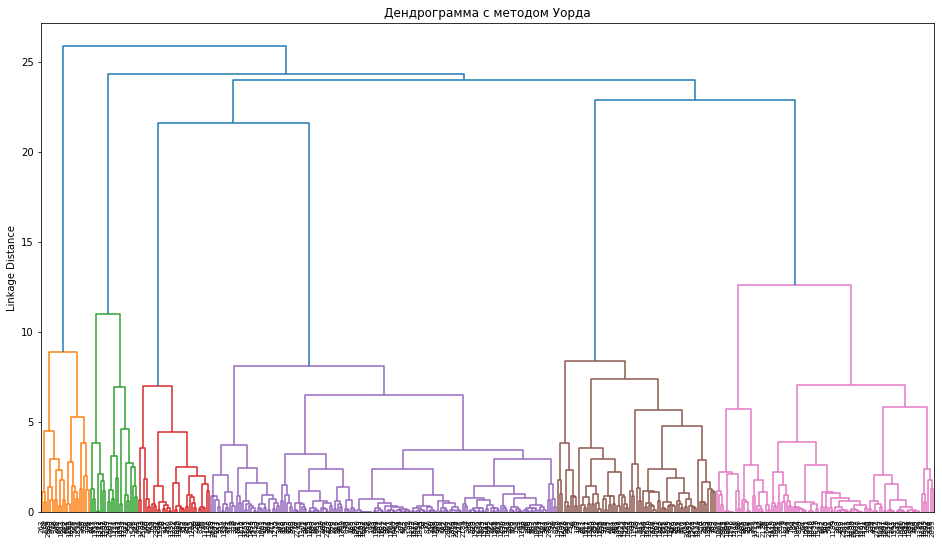

In [92]:
Z = clst.hierarchy.linkage(data, method='ward')
plt.figure(figsize=(16, 9))
dn = clst.hierarchy.dendrogram(Z, labels=data.index)
plt.xticks(rotation='vertical', fontsize=7)
plt.title('Дендрограмма с методом Уорда')
plt.ylabel('Linkage Distance');

In [93]:
from sklearn.cluster import AgglomerativeClustering

# Указать количество кластеров в параметре n_clusters
clust = AgglomerativeClustering(n_clusters=6, linkage='ward', affinity='euclidean')
dataset['cluster'] = clust.fit_predict(data)
dataset['cluster'].value_counts()

/Users/user/shit/zakupki-analytics/venv/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


3    164
0    103
4     75
5     34
1     23
2     23
Name: cluster, dtype: int64

In [94]:
# Сводная таблица средних значений по кластерам
pivot_table = dataset.groupby('cluster')[calculated_features].mean()
pivot_table

,mean_economy_placer_supplier,mean_contract_sum_placer_supplier,mean_contract_positions_placer_supplier,percent_placer_with_supplier_contracts,percent_supplier_with_placer_contracts
cluster,,,,,
0,-0.268205,-0.346150,-0.242273,1.351817,0.025155
1,3.676102,-0.130262,-0.126042,-0.179787,0.437728
2,-0.208096,0.207349,3.427552,0.528582,0.308424
3,-0.221486,-0.268508,-0.148805,-0.627731,0.517721
4,-0.143607,-0.134545,-0.202299,-0.432765,-1.646766
5,-0.148375,2.588432,-0.335416,-0.348655,0.554377


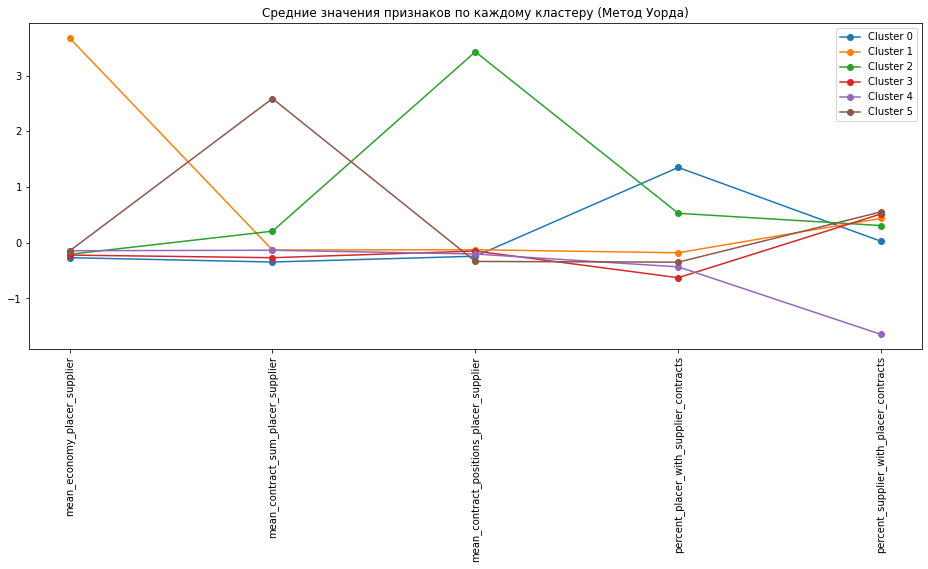

In [95]:
# Графики средних значений по кластерам

plt.figure(figsize=(16, 6))

for cluster in pivot_table.T.columns:
    plt.plot(pivot_table.T[cluster], 'o-', label=f'Cluster {cluster}')
plt.xticks(rotation='vertical')
plt.title('Средние значения признаков по каждому кластеру (Метод Уорда)')
plt.legend();

In [96]:
from sklearn.cluster import KMeans
clust = KMeans(n_clusters=6)
dataset['cluster'] = clust.fit_predict(data)
dataset['cluster'].value_counts()

/Users/user/shit/zakupki-analytics/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


2    183
1     87
4     71
0     43
5     20
3     18
Name: cluster, dtype: int64

In [97]:
# Сводная таблица средних значений по кластерам
pivot_table = dataset.groupby('cluster')[calculated_features].mean()
pivot_table

,mean_economy_placer_supplier,mean_contract_sum_placer_supplier,mean_contract_positions_placer_supplier,percent_placer_with_supplier_contracts,percent_supplier_with_placer_contracts
cluster,,,,,
0,-0.169278,2.492614,-0.167265,-0.297490,0.374776
1,-0.207992,-0.380675,-0.243395,1.393883,0.332943
2,-0.236255,-0.283821,-0.152249,-0.594426,0.450238
3,-0.199154,-0.248821,3.923851,0.793127,0.235258
4,-0.116973,-0.230936,-0.155556,-0.065221,-1.972702
5,4.024944,-0.062460,-0.167777,-0.467068,0.417614


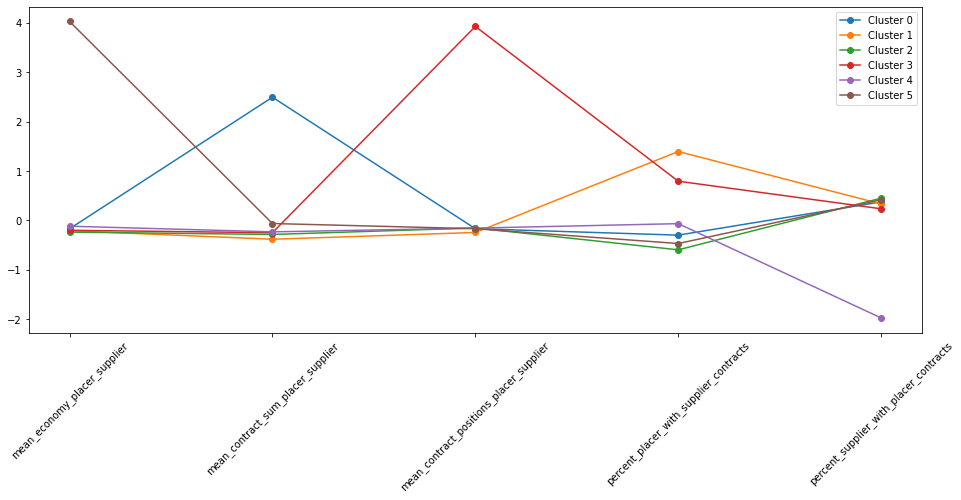

In [100]:
# Графики средних значений по кластерам

plt.figure(figsize=(16, 6))

for cluster in pivot_table.T.columns:
    plt.plot(pivot_table.T[cluster], 'o-', label=f'Cluster {cluster}')
plt.xticks(rotation=45)
#plt.title('Средние значения признаков по каждому кластеру (К-средних)')
plt.legend();

In [101]:
cl = dataset[
    (dataset['cluster'] == 0)
    | (dataset['cluster'] == 1)
    | (dataset['cluster'] == 3)
]
data = cl[calculated_features]
cl

,supplier_inn,contract_placer_inn,mean_economy_placer_supplier,mean_contract_sum_placer_supplier,mean_contract_positions_placer_supplier,percent_placer_with_supplier_contracts,percent_supplier_with_placer_contracts,cluster
3,6671095570,6623050480,-0.258187,-0.297005,0.355191,1.142100,0.571821,1
7,6454074043,6454006283,-0.258187,-0.673852,-0.180349,1.001151,0.571821,1
12,7203360033,7203000538,-0.258187,-0.434460,-0.389152,1.020632,-0.614386,1
21,672403318182,6731000014,-0.258187,-0.519446,-0.389152,2.053108,0.571821,1
27,9717012574,7717022723,-0.258187,1.320747,-0.389152,-0.269963,0.571821,0
...,...,...,...,...,...,...,...,...
2509,4345502070,4345086060,-0.258187,4.145583,-0.389152,2.053108,0.571821,0
2512,4345316588,1826000260,-0.195442,-0.563999,-0.389152,1.020632,0.571821,1
2607,7451344670,7453014519,-0.258187,1.715717,1.234870,-0.159341,0.571821,0
2714,1435157979,1435029085,-0.258187,-0.799038,-0.389152,1.020632,-0.614386,1


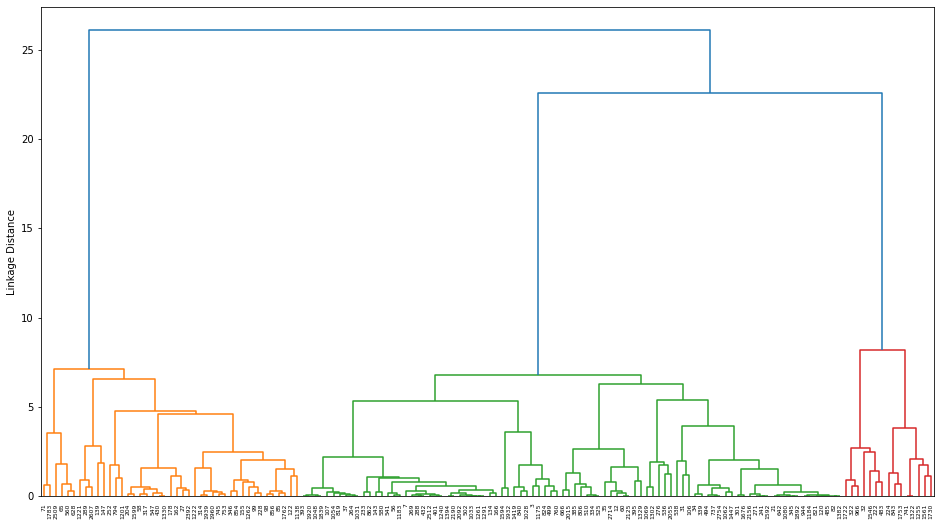

In [131]:
Z = clst.hierarchy.linkage(data, method='ward')
plt.figure(figsize=(16, 9))
dn = clst.hierarchy.dendrogram(Z, labels=data.index)
plt.xticks(rotation='vertical', fontsize=6)
plt.ylabel('Linkage Distance');

In [127]:
clust = KMeans(n_clusters=3)
cl['cluster'] = clust.fit_predict(data)
cl['cluster'].value_counts()

/Users/user/shit/zakupki-analytics/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


2    87
1    43
0    18
Name: cluster, dtype: int64

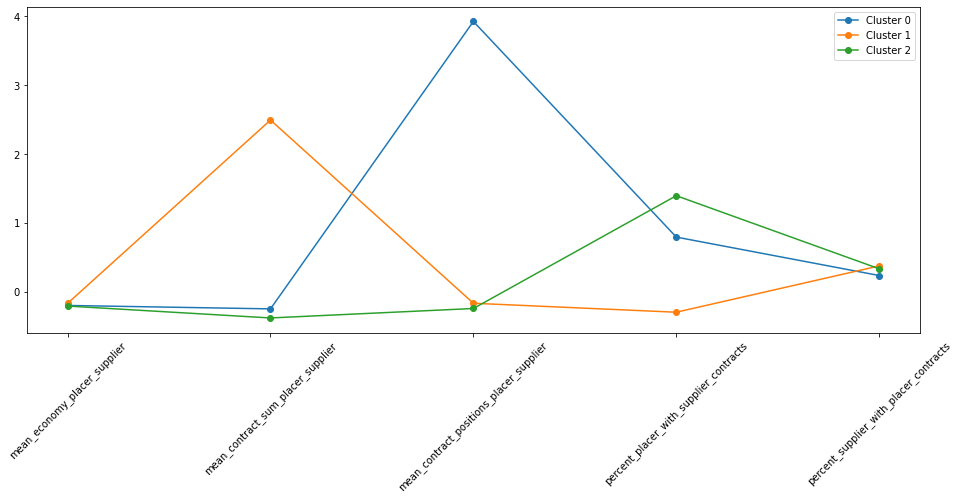

In [132]:
pivot_table = cl.groupby('cluster')[calculated_features].mean()

plt.figure(figsize=(16, 6))

for cluster in pivot_table.T.columns:
    plt.plot(pivot_table.T[cluster], 'o-', label=f'Cluster {cluster}')
plt.xticks(rotation=45)
plt.legend();

In [129]:
cl[cl['cluster'] == 1]

,supplier_inn,contract_placer_inn,mean_economy_placer_supplier,mean_contract_sum_placer_supplier,mean_contract_positions_placer_supplier,percent_placer_with_supplier_contracts,percent_supplier_with_placer_contracts,cluster
27,9717012574,7717022723,-0.258187,1.320747,-0.389152,-0.269963,0.571821,1
58,7842033539,7830000426,-0.258187,1.676999,-0.389152,-0.830705,0.571821,1
65,7802642936,7812003110,-0.258187,3.684245,-0.389152,0.725639,0.571821,1
71,7725258514,7709378229,1.338887,4.290932,-0.389152,0.504394,0.571821,1
85,3257003746,3201001120,-0.258187,2.517008,-0.389152,-0.894883,0.571821,1
98,7810672363,7830000426,-0.258187,2.212857,-0.389152,-0.937513,0.571821,1
99,2466280572,2460213509,-0.258187,2.528351,-0.389152,-0.159341,0.571821,1
122,7725285067,3443012297,-0.123416,2.965922,0.625862,-0.791469,0.571821,1
147,7725628067,3443012297,-0.257358,3.586215,1.640875,-0.412192,0.571821,1
155,7203485321,7202032343,-0.258187,2.376772,-0.389152,-0.183924,-0.021283,1


Заказчик
6731000014 - https://www.rusprofile.ru/id/1314755 ОГУЭПП "Смоленскоблкоммунэнерго"
Поставщик
672403318182 - https://www.rusprofile.ru/ip/316673300064107 ИП Благовисный Павел Михайлович
6 договоров, заказчик и поставщик всегда вместе.
все договоры по аварийно-восстановительным работам с признаком emergency
таких договоров было 9, из них удалось определить поставщика по 6 и все с один ИП.
экономия в 6 договорах нулевая
есть предположения что имеет место сговор.

In [49]:
cl[cl['cluster'] == 5]

,supplier_inn,contract_placer_inn,mean_economy_placer_supplier,mean_contract_sum_placer_supplier,mean_contract_positions_placer_supplier,percent_placer_with_supplier_contracts,percent_supplier_with_placer_contracts,cluster


Заказчик:
4700000130 - https://www.rusprofile.ru/id/2690332 ЛОГП "Ленфарм"
Поставщик:
7810295612 - https://www.rusprofile.ru/id/2351785 ООО "Стальпроминвест"

В ковидную выборку от поставщика попало 12 договоров
по всем удалось найти поставщиков.

Из них 7 заключено со стальпроминвест.
Все 7 договоров имеют категорию медмат.
Предмет закупки у всех - Маска гигиеническая, трехслойная, одноразовая, производитель Китай.
Все договора были заключены с апреля по май 2020ого года.

Подозрительно:
1) Маски производства китая
2) Основная деятельность Стальпроминвест - Производство искусственного графита, коллоидного или полуколлоидного графита, продуктов на основе графита или прочих форм углерода в виде полуфабрикатов (23.99.4)
3) Все закупки имеют способ закупки иной способ, но на каждую закупку было подано по одной заявке
4) Нулевая экономия
5) в сумме было закуплено 1390860 масок на 33281660 рублей (23,9 рублей за маску)